# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model; compute_MAP=true);

In [9]:
target.vsyms[1]

Ωm

In [40]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       monitor_energy=true, 
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852954027, 0.06088870443747089] ✅


eps: 0.5 --> VarE: 3.6496830025466123
eps: 0.035336806432600724 --> VarE: 0.18211318446075753
eps: 0.08006284681211553 --> VarE: 0.49606225999810766
eps: 0.1325221301416146 --> VarE: 0.8928422205101082
eps: 0.1475116905944565 --> VarE: 1.0150994628626042
samples: 100--> ESS: 0.0143251199875072
samples: 203--> ESS: 0.014963260926006484
samples: 310--> ESS: 0.01697838654750044
samples: 420--> ESS: 0.02051008546218396
samples: 534--> ESS: 0.018876410733492593


[ Info: Found eps: 0.1475116905944565 ✅
[ Info: Found L: 3.125841934191973 ✅


In [41]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

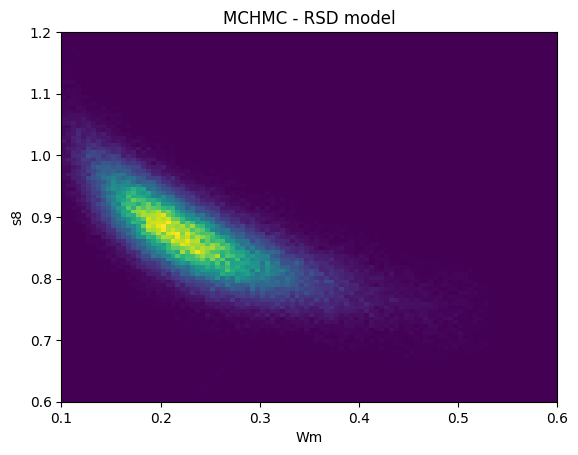

In [42]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [43]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

eps: 0.5 --> VarE: 2.1108950769016004


[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.09985438966811573 --> VarE: 8.629870274668258
eps: 2.9417743886162907e-5 --> VarE: 2.9796808980849456e-8
eps: 4.850165863593077e-5 --> VarE: 2.0812635654468095e-7
eps: 7.996569961432414e-5 --> VarE: 1.4020525753702452e-6
eps: 0.0001318409650324591 --> VarE: 1.073063951321125e-5
eps: 0.00021736667090274499 --> VarE: 6.500237254119803e-5
eps: 0.00035835375925697544 --> VarE: 0.000356532554205003
eps: 0.0005906148543571512 --> VarE: 0.0011451724266607912
eps: 0.0009726447891602293 --> VarE: 0.0031913936245588433
eps: 0.0015985105273422183 --> VarE: 0.003502993957499286
eps: 0.0026262823244109982 --> VarE: 0.0032113234551151247
eps: 0.004316124779308534 --> VarE: 0.012621288935031122
eps: 0.0070268369523124085 --> VarE: 0.042072558907061526
eps: 0.01110798378855067 --> VarE: 0.2293755645530392
eps: 0.014560152919864986 --> VarE: 0.5938362161470937
eps: 0.013256027163958057 --> VarE: 0.457921388986308
Initial Virial loss: 12593.075595046264
Initial sigma: [1.6553728403561843, 0.30980

[ Info: VarE condition met during eps tuning at step: 17
[ Info: Found eps: 0.013256027163958057 ✅


Sigma --> [1.6131329130487924, 0.29053587087517074]
Virial loss: 75.77492249221542 --> Relative improvement: 0.024741114075794934
Sigma --> [1.6104260245533788, 0.2894503916290041]
Virial loss: 73.90222372998228 --> Relative improvement: 0.024713964734513927
Sigma --> [1.607694787631631, 0.2883770818802255]
Virial loss: 72.07967934778888 --> Relative improvement: 0.02466156348491566
Sigma --> [1.6049399709788714, 0.2873156401683196]
Virial loss: 70.30735511222842 --> Relative improvement: 0.024588403439045337
Sigma --> [1.6021623350211087, 0.28626578625807186]
Virial loss: 68.58469873800948 --> Relative improvement: 0.024501794605545135
Sigma --> [1.5993626251876518, 0.28522725531498455]
Virial loss: 66.91046642266728 --> Relative improvement: 0.02441116380400954
Sigma --> [1.5965416223246136, 0.2841997911321554]
Virial loss: 65.28271485775097 --> Relative improvement: 0.024327308595249564
Sigma --> [1.5937002462449117, 0.2831831391491661]
Virial loss: 63.69884192385521 --> Relative im

Virial loss: 3.8254805955554647 --> Relative improvement: 0.02877579545152087
Sigma --> [1.3952191083118899, 0.22805806328192424]
Virial loss: 3.7151083369996996 --> Relative improvement: 0.02885186731413525
Sigma --> [1.39306732257439, 0.22752805252598304]
Virial loss: 3.6082720024426425 --> Relative improvement: 0.02875725951059005
Sigma --> [1.3909299702474727, 0.22700206998800326]


┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:196
[ Info: Found sigma: [1.3909299702474727, 0.22700206998800326] ✅


eps: 0.013256027163958057 --> VarE: 9.143526132622622e-5
eps: 0.013934404056117828 --> VarE: 0.00012452323654657172
eps: 0.014647012222490562 --> VarE: 0.0001416615958399722
eps: 0.015395799449762588 --> VarE: 0.00016480050942331334
eps: 0.0161824918644704 --> VarE: 0.00019534229464809676
eps: 0.01700886308957417 --> VarE: 0.00023479569105886648
eps: 0.01787672827671493 --> VarE: 0.00028523381246097385
eps: 0.018787928018391572 --> VarE: 0.00035061381049186156
eps: 0.01974428185490719 --> VarE: 0.0004387012504712779
eps: 0.02074748888663655 --> VarE: 0.0005626378757187285
eps: 0.021798967013407774 --> VarE: 0.0006087702591728255
eps: 0.022902677238550235 --> VarE: 0.0008018367455470839
eps: 0.024057624587214176 --> VarE: 0.0010784262654853932
eps: 0.025263825506772752 --> VarE: 0.0014644258053742333
eps: 0.026520264129192492 --> VarE: 0.0019823690508309075
eps: 0.027824773468644957 --> VarE: 0.002647868154293485
eps: 0.02917402876620723 --> VarE: 0.004131013711354869
eps: 0.03054337712

[ Info: VarE condition met during eps tuning at step: 55
[ Info: Found eps: 0.06834395845400087 ✅


In [44]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

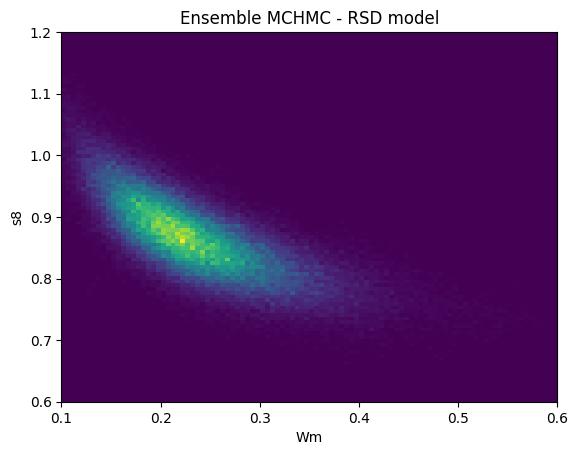

In [45]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    monitor_energy=true, 
    dialog=true)

LoadError: UndefVarError: `MCHMC` not defined

In [15]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

LoadError: UndefVarError: `MCHMC` not defined

In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

LoadError: UndefVarError: `MCHMC` not defined

In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 13.33 seconds
Compute duration  = 13.33 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2393    0.0677     0.0007    0.0016   1752.3964    1.0000    ⋯
          σ8    0.8648    0.0619     0.0006    0.0012   2508.4763    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.346924  0.790773  14.9465  19.0  1.0  …  4.0  0.0  0.0453996  0.0453996
 0.336729  0.762303  14.5147   7.0  1.0     2.0  0.0  0.0453996  0.0453996
 0.31416   0.819226  15.4936  11.0  1.0     3.0  0.0  0.0453996  0.0453996
 0.31416   0.819226  15.4936   3.0  1.0     1.0  0.0  0.0453996  0.0453996
 0.190353  0.919131  15.9618  19.0  1.0     4.0  0.0  0.0453996  0.0453996
 0.222322  0.876565  16.2844  23.0  1.0  …  4.0  0.0  0.0453996  0.0453996
 0.195883  0.895707  16.1915  27.0  1.0     4.0  0.0  0.0453996  0.0453996
 0.186104  0.842996  15.0478   7.0  1.0     2.0  0.0  0.0453996  0.0453996
 0.23137   0.79984   14.9998  15.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

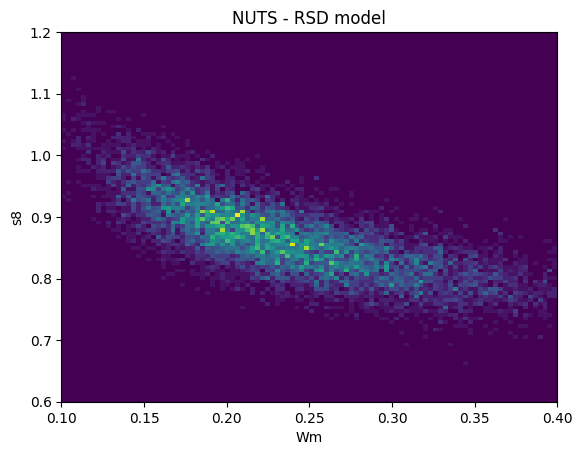

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");